# **Gesture Recognition using Machine Learning**

Below we combine all required preprocessing steps into a single cell—matching the Data Exploration notebook (window size = 250, train step = 125, val/test step = 250)—and then run the ML workflow: feature extraction, PCA, and model tuning.

In [1]:
from google.colab import drive

_drive_path = '/content/drive'
drive.mount(_drive_path, force_remount=False)


Mounted at /content/drive


In [8]:
import os
import glob
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.utils import to_categorical

from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GroupShuffleSplit, ParameterGrid, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


from tqdm import tqdm

np.random.seed(42)


### Data Preparation

We load, filter, segment, split, window, stack, normalize, and one-hot–encode exactly as before.


In [3]:
root_dir = "/content/drive/MyDrive/IA_EBM/PROJECT/EMG_data_for_gestures-master"
all_txt  = glob.glob(os.path.join(root_dir, "**", "*.txt"), recursive=True)

# Load & concatenate
dfs = [pd.read_csv(f, sep="\t") for f in all_txt]
df  = pd.concat(dfs, ignore_index=True)

# Drop classes 0 & 7 (unmarked / extended palm)
df = df[~df['class'].isin([0, 7])].reset_index(drop=True)

# Create a segment ID each time the gesture label changes
df['segment'] = (df['class'] != df['class'].shift()).cumsum()

# Build per-segment dict
gesture_datasets = {
    f"gesture_{int(cls)}_{seg}": grp
    for (cls, seg), grp in df.groupby(['class','segment'])
}

# train/val/test splits by segment (60/20/20)
classes   = sorted({int(k.split('_')[1]) for k in gesture_datasets})
train_segs = []; val_segs = []; test_segs = []
for cls in classes:
    keys = [k for k in gesture_datasets if int(k.split('_')[1])==cls]
    random.shuffle(keys)
    n = len(keys)
    train_segs += keys[:int(0.6*n)]
    val_segs   += keys[int(0.6*n):int(0.8*n)]
    test_segs  += keys[int(0.8*n):]

# sliding windows: 250 samples, 125-step train, 250-step val/test
WINDOW_SIZE = 250
train_w, val_w, test_w = {}, {}, {}
for key, grp in gesture_datasets.items():
    sig = grp.filter(like="channel").to_numpy().T
    if   key in train_segs: step = 125; target = train_w
    elif key in val_segs:   step = 250; target = val_w
    else:                   step = 250; target = test_w

    for i in range(0, sig.shape[1]-WINDOW_SIZE+1, step):
        target[f"{key}_win_{i//step}"] = sig[:, i:i+WINDOW_SIZE].T

# stack and label
def prepare(wdict):
    X = np.stack([w.T for w in wdict.values()], axis=0)
    y = np.array([int(k.split('_')[1]) for k in wdict.keys()])
    return X, y

X_train, y_train = prepare(train_w)
X_val,   y_val   = prepare(val_w)
X_test,  y_test  = prepare(test_w)

# normalize by train stats
mean = X_train.mean((0,1), keepdims=True)
std  = X_train.std((0,1), keepdims=True) + 1e-8
for arr in (X_train, X_val, X_test):
    arr[:] = (arr - mean) / std

# one-hot encode
offset       = y_train.min()
num_classes  = y_train.max() - offset + 1
y_train_enc  = to_categorical(y_train - offset, num_classes)
y_val_enc    = to_categorical(y_val   - offset, num_classes)
y_test_enc   = to_categorical(y_test  - offset, num_classes)

## Feature Extraction from EMG Windows

We compute a suite of time-domain features for each fixed-length window:
- Mean, std, min, max  
- Skewness, kurtosis  
- RMS and energy  
- Zero-crossings  

In [4]:
def extract_features(window):
    """
    window: ndarray (time_steps, n_channels)
    returns: concatenated feature vector for all channels
    """
    diffs = np.diff(window, axis=0)  # first-order differences
    feats = [
        np.mean(window, axis=0),       # mean per channel
        np.std(window, axis=0),        # standard deviation
        np.min(window, axis=0),        # minimum value
        np.max(window, axis=0),        # maximum value
        stats.skew(window, axis=0),    # skewness
        stats.kurtosis(window, axis=0),# kurtosis
        np.sqrt(np.mean(window**2, axis=0)),  # RMS
        np.sum(window**2, axis=0),            # signal energy
        np.sum((window[:-1]*window[1:])<0, axis=0)  # zero-crossings
    ]
    return np.concatenate(feats)

def make_feature_set(wdict, split_name):
    X_feat, y_lbl, groups = [], [], []
    for key, w in tqdm(wdict.items(), desc=f"Extracting features ({split_name})"):
        X_feat.append(extract_features(w))             # extract features
        cls = int(key.split('_')[1])                   # get class label
        y_lbl.append(cls)
        groups.append(key.rsplit('_win_',1)[0])        # group by original segment
    return np.vstack(X_feat), np.array(y_lbl), np.array(groups)

# Build feature sets for each split
Xtr_ft, ytr_ft, grp_tr = make_feature_set(train_w, "Train")
Xva_ft, yva_ft, grp_va = make_feature_set(val_w,   "Val")
Xte_ft, yte_ft, grp_te = make_feature_set(test_w,  "Test")

print("Feature shapes:", Xtr_ft.shape, Xva_ft.shape, Xte_ft.shape)


Extracting features (Test): 100%|██████████| 1112/1112 [00:04<00:00, 229.61it/s]

Feature shapes: (6457, 72) (1103, 72) (1112, 72)


## Scaling and PCA

Standardize features then apply PCA to keep 95% of variance.


In [5]:
# Standardize features
scaler = StandardScaler().fit(Xtr_ft)
Xtr_s  = scaler.transform(Xtr_ft)
Xva_s  = scaler.transform(Xva_ft)
Xte_s  = scaler.transform(Xte_ft)

# To avoid passing NaNs
Xtr_s = np.nan_to_num(Xtr_s, nan=0.0, posinf=0.0, neginf=0.0)
Xva_s = np.nan_to_num(Xva_s, nan=0.0, posinf=0.0, neginf=0.0)
Xte_s = np.nan_to_num(Xte_s, nan=0.0, posinf=0.0, neginf=0.0)

# Apply PCA
pca = PCA(0.95, random_state=42).fit(Xtr_s)
Xtr_p = pca.transform(Xtr_s)
Xva_p = pca.transform(Xva_s)
Xte_p = pca.transform(Xte_s)

print(f"PCA reduced {Xtr_ft.shape[1]} → {Xtr_p.shape[1]} features")


PCA reduced 72 → 35 features




---

## k-Nearest Neighbors Tuning

We search over `n_neighbors` using 3× repeated, group-aware 5-fold cross‐validation.


In [9]:

def tune_knn(
    X_train, y_train, groups,
    ks,
    X_test=None, y_test=None,
    n_splits=5, train_size=0.8, random_state=42
):
    """
    Tune KNN (n_neighbors in ks) with GroupShuffleSplit CV,
    retrain on all training data, and (optionally) evaluate on test.
    """
    best_k, best_val = None, -np.inf

    # group-aware splitter
    cv = GroupShuffleSplit(
        n_splits=n_splits,
        train_size=train_size,
        random_state=random_state
    )

    # search ks
    for k in tqdm(ks, desc="Tuning KNN"):
        clf = KNeighborsClassifier(n_neighbors=k)
        res = cross_validate(
            clf, X_train, y_train,
            groups=groups, cv=cv,
            return_train_score=True, n_jobs=-1
        )
        tr_m, tr_v = res['train_score'].mean(), res['train_score'].var()
        v_m, v_v = res['test_score'].mean(),  res['test_score'].var()
        print(f"k={k}: train {tr_m:.3f}±{tr_v:.4f}, val {v_m:.3f}±{v_v:.4f}")

        if v_m > best_val:
            best_val, best_k = v_m, k

    print(f"\n→ Best k = {best_k} (val acc = {best_val:.3f})\n")

    # retrain on full train set
    best_model = KNeighborsClassifier(n_neighbors=best_k)
    best_model.fit(X_train, y_train)

    # final evaluation & single CM display
    if X_test is not None and y_test is not None:
        y_pred = best_model.predict(X_test)
        labels = np.unique(y_test)  # e.g. array([1,2,3,4,5,6])
        cm = confusion_matrix(y_test, y_pred, labels=labels)

        # plot heatmap with properly aligned ticks
        fig, ax = plt.subplots(figsize=(6,6))
        im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

        # positions 0..len(labels)-1, but label them with actual class names
        tick_pos = np.arange(len(labels))
        ax.set_xticks(tick_pos)
        ax.set_xticklabels(labels)
        ax.set_yticks(tick_pos)
        ax.set_yticklabels(labels)

        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title("Confusion Matrix")

        # annotate counts
        thresh = cm.max() / 2
        for i in range(len(labels)):
            for j in range(len(labels)):
                color = "white" if cm[i, j] > thresh else "black"
                ax.text(j, i, cm[i, j], ha="center", va="center", color=color)

        fig.colorbar(im, ax=ax)
        plt.tight_layout()
        plt.show()

        # classification report
        print("\nClassification Report:\n",
              classification_report(y_test, y_pred, digits=3))

    return best_model

Tuning KNN:  14%|█▍        | 1/7 [00:02<00:13,  2.25s/it]

k=3: train 0.967±0.0000, val 0.790±0.0003


Tuning KNN:  29%|██▊       | 2/7 [00:05<00:13,  2.63s/it]

k=5: train 0.948±0.0000, val 0.805±0.0003


Tuning KNN:  43%|████▎     | 3/7 [00:09<00:14,  3.63s/it]

k=7: train 0.934±0.0000, val 0.813±0.0003


Tuning KNN:  57%|█████▋    | 4/7 [00:13<00:11,  3.70s/it]

k=9: train 0.926±0.0000, val 0.819±0.0006


Tuning KNN:  71%|███████▏  | 5/7 [00:17<00:07,  3.64s/it]

k=15: train 0.908±0.0000, val 0.820±0.0006


Tuning KNN:  86%|████████▌ | 6/7 [00:20<00:03,  3.65s/it]

k=20: train 0.897±0.0000, val 0.819±0.0007


Tuning KNN: 100%|██████████| 7/7 [00:23<00:00,  3.37s/it]

k=50: train 0.868±0.0000, val 0.814±0.0006

→ Best k = 15 (val acc = 0.820)



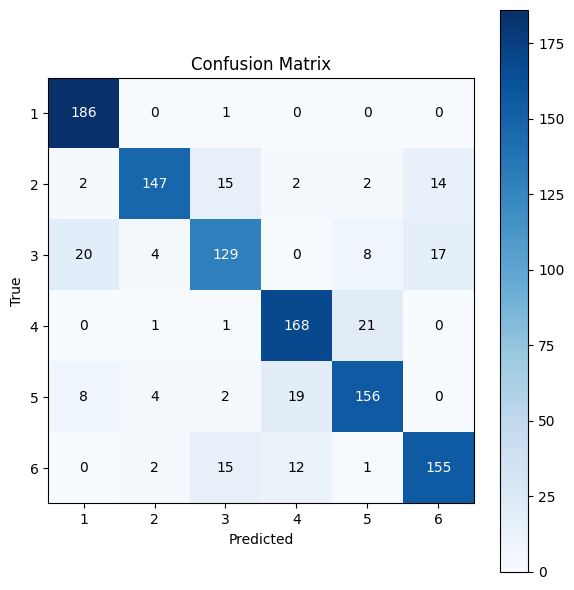


Classification Report:
               precision    recall  f1-score   support

           1      0.861     0.995     0.923       187
           2      0.930     0.808     0.865       182
           3      0.791     0.725     0.757       178
           4      0.836     0.880     0.857       191
           5      0.830     0.825     0.828       189
           6      0.833     0.838     0.836       185

    accuracy                          0.846      1112
   macro avg      0.847     0.845     0.844      1112
weighted avg      0.847     0.846     0.845      1112



In [10]:
knn = tune_knn(Xtr_p, ytr_ft, grp_tr, ks=[3, 5, 7, 9, 15, 20, 50],X_test=Xte_p, y_test=yte_ft)



---
## Random Forest
We search over `n_estimators` and `max_depth` using repeated, group-aware CV.


In [11]:
def tune_rf(
    X_train, y_train, groups,
    param_grid,
    X_test=None, y_test=None,
    n_splits=5, train_size=0.8, random_state=42
):

    best_params, best_val = None, -np.inf

    # group-aware splitter
    cv = GroupShuffleSplit(
        n_splits=n_splits,
        train_size=train_size,
        random_state=random_state
    )

    # grid search
    for params in tqdm(ParameterGrid(param_grid), desc="Tuning RF"):
        clf = RandomForestClassifier(
            **params,
            random_state=random_state,
            n_jobs=-1
        )
        res = cross_validate(
            clf, X_train, y_train,
            groups=groups, cv=cv,
            return_train_score=True, n_jobs=-1
        )
        tr_m, tr_v = res['train_score'].mean(), res['train_score'].var()
        v_m, v_v = res['test_score'].mean(),  res['test_score'].var()
        print(f"{params}: train {tr_m:.3f}±{tr_v:.4f}, val {v_m:.3f}±{v_v:.4f}")

        if v_m > best_val:
            best_val, best_params = v_m, params

    print(f"\n→ Best params = {best_params} (val acc = {best_val:.3f})\n")

    # retrain on full train set
    best_model = RandomForestClassifier(
        **best_params,
        random_state=random_state,
        n_jobs=-1
    )
    best_model.fit(X_train, y_train)

    # final evaluation & single CM display
    if X_test is not None and y_test is not None:
        y_pred = best_model.predict(X_test)
        labels = np.unique(y_test)  # e.g. array([1,2,3,4,5,6])
        cm = confusion_matrix(y_test, y_pred, labels=labels)

        # plot heatmap with properly aligned ticks
        fig, ax = plt.subplots(figsize=(6,6))
        im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

        # positions 0..len(labels)-1, but label them with actual class names
        tick_pos = np.arange(len(labels))
        ax.set_xticks(tick_pos)
        ax.set_xticklabels(labels)
        ax.set_yticks(tick_pos)
        ax.set_yticklabels(labels)

        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title("Confusion Matrix")

        # annotate counts
        thresh = cm.max() / 2
        for i in range(len(labels)):
            for j in range(len(labels)):
                color = "white" if cm[i, j] > thresh else "black"
                ax.text(j, i, cm[i, j], ha="center", va="center", color=color)

        fig.colorbar(im, ax=ax)
        plt.tight_layout()
        plt.show()

        # classification report
        print("\nClassification Report:\n",
              classification_report(y_test, y_pred, digits=3))

    return best_model

Tuning RF:  11%|█         | 1/9 [00:09<01:14,  9.37s/it]

{'max_depth': None, 'n_estimators': 50}: train 1.000±0.0000, val 0.829±0.0008


Tuning RF:  22%|██▏       | 2/9 [00:28<01:46, 15.23s/it]

{'max_depth': None, 'n_estimators': 100}: train 1.000±0.0000, val 0.834±0.0006


Tuning RF:  33%|███▎      | 3/9 [01:09<02:42, 27.07s/it]

{'max_depth': None, 'n_estimators': 200}: train 1.000±0.0000, val 0.837±0.0007


Tuning RF:  44%|████▍     | 4/9 [01:14<01:30, 18.11s/it]

{'max_depth': 5, 'n_estimators': 50}: train 0.824±0.0001, val 0.788±0.0022


Tuning RF:  56%|█████▌    | 5/9 [01:25<01:02, 15.62s/it]

{'max_depth': 5, 'n_estimators': 100}: train 0.827±0.0000, val 0.794±0.0023


Tuning RF:  67%|██████▋   | 6/9 [01:56<01:02, 20.80s/it]

{'max_depth': 5, 'n_estimators': 200}: train 0.827±0.0001, val 0.795±0.0025


Tuning RF:  78%|███████▊  | 7/9 [02:08<00:36, 18.00s/it]

{'max_depth': 10, 'n_estimators': 50}: train 0.967±0.0000, val 0.826±0.0010


Tuning RF:  89%|████████▉ | 8/9 [02:24<00:17, 17.35s/it]

{'max_depth': 10, 'n_estimators': 100}: train 0.970±0.0000, val 0.830±0.0010


Tuning RF: 100%|██████████| 9/9 [02:56<00:00, 19.60s/it]

{'max_depth': 10, 'n_estimators': 200}: train 0.970±0.0000, val 0.833±0.0010

→ Best params = {'max_depth': None, 'n_estimators': 200} (val acc = 0.837)



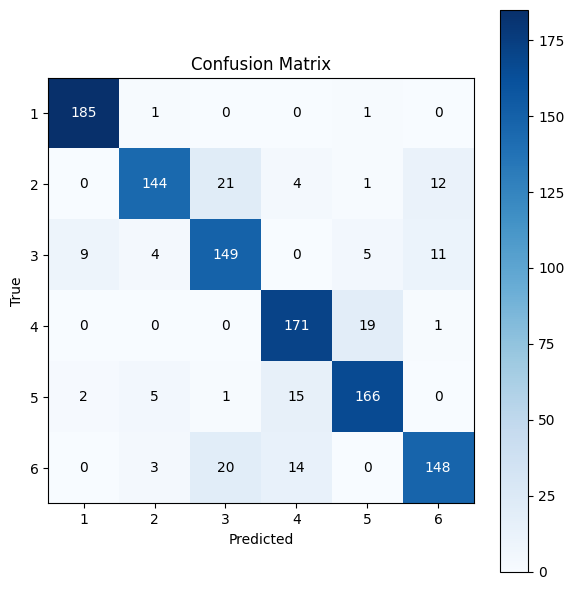


Classification Report:
               precision    recall  f1-score   support

           1      0.944     0.989     0.966       187
           2      0.917     0.791     0.850       182
           3      0.780     0.837     0.808       178
           4      0.838     0.895     0.866       191
           5      0.865     0.878     0.871       189
           6      0.860     0.800     0.829       185

    accuracy                          0.866      1112
   macro avg      0.867     0.865     0.865      1112
weighted avg      0.868     0.866     0.866      1112



In [12]:
rf_model = tune_rf(X_train=Xtr_p, y_train=ytr_ft, groups=grp_tr, param_grid={'n_estimators':[50,100,200], 'max_depth':[None,5,10]}, X_test=Xte_p, y_test=yte_ft)



---
# Support Vector Machine

Tune `C` and `kernel` for an SVM, using the same repeated group CV approach.


In [13]:
def tune_svm(
    X_train, y_train, groups,
    param_grid,
    X_test=None, y_test=None,
    n_splits=5, train_size=0.8, random_state=42
):
    """
    Tune SVM over param_grid with GroupShuffleSplit CV,
    retrain on all training data, and (optionally) evaluate on test.
    """
    best_params, best_val = None, -np.inf

    # group-aware splitter
    cv = GroupShuffleSplit(
        n_splits=n_splits,
        train_size=train_size,
        random_state=random_state
    )

    # grid search
    for params in tqdm(ParameterGrid(param_grid), desc="Tuning SVM"):
        clf = SVC(**params, random_state=random_state)
        res = cross_validate(
            clf, X_train, y_train,
            groups=groups, cv=cv,
            return_train_score=True, n_jobs=-1
        )
        tr_m, tr_v = res['train_score'].mean(), res['train_score'].var()
        v_m, v_v = res['test_score'].mean(),  res['test_score'].var()
        print(f"{params}: train {tr_m:.3f}±{tr_v:.4f}, val {v_m:.3f}±{v_v:.4f}")

        if v_m > best_val:
            best_val, best_params = v_m, params

    print(f"\n→ Best params = {best_params} (val acc = {best_val:.3f})\n")

    # retrain on full train set
    best_model = SVC(**best_params, random_state=random_state)
    best_model.fit(X_train, y_train)

    # final evaluation & single CM display
    if X_test is not None and y_test is not None:
        y_pred = best_model.predict(X_test)
        labels = np.unique(y_test)  # e.g. array([1,2,3,4,5,6])
        cm = confusion_matrix(y_test, y_pred, labels=labels)

        # plot heatmap with properly aligned ticks
        fig, ax = plt.subplots(figsize=(6,6))
        im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

        # positions 0..len(labels)-1, but labeled with actual class names
        tick_pos = np.arange(len(labels))
        ax.set_xticks(tick_pos)
        ax.set_xticklabels(labels)
        ax.set_yticks(tick_pos)
        ax.set_yticklabels(labels)

        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title("Confusion Matrix")

        # annotate counts
        thresh = cm.max() / 2
        for i in range(len(labels)):
            for j in range(len(labels)):
                color = "white" if cm[i, j] > thresh else "black"
                ax.text(j, i, cm[i, j], ha="center", va="center", color=color)

        fig.colorbar(im, ax=ax)
        plt.tight_layout()
        plt.show()

        # classification report
        print("\nClassification Report:\n",
              classification_report(y_test, y_pred, digits=3))

    return best_model

Tuning SVM:   8%|▊         | 1/12 [00:04<00:47,  4.31s/it]

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}: train 0.883±0.0000, val 0.826±0.0005


Tuning SVM:  17%|█▋        | 2/12 [00:22<02:04, 12.43s/it]

{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}: train 0.864±0.0000, val 0.824±0.0002


Tuning SVM:  25%|██▌       | 3/12 [00:29<01:28,  9.85s/it]

{'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}: train 0.883±0.0000, val 0.826±0.0005


Tuning SVM:  33%|███▎      | 4/12 [00:49<01:51, 13.93s/it]

{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}: train 0.857±0.0000, val 0.788±0.0004


Tuning SVM:  42%|████▏     | 5/12 [00:55<01:18, 11.18s/it]

{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}: train 0.889±0.0000, val 0.829±0.0005


Tuning SVM:  50%|█████     | 6/12 [01:11<01:16, 12.83s/it]

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}: train 0.949±0.0000, val 0.860±0.0004


Tuning SVM:  58%|█████▊    | 7/12 [01:19<00:55, 11.03s/it]

{'C': 1, 'gamma': 'auto', 'kernel': 'linear'}: train 0.889±0.0000, val 0.829±0.0005


Tuning SVM:  67%|██████▋   | 8/12 [01:33<00:48, 12.16s/it]

{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}: train 0.975±0.0000, val 0.851±0.0003


Tuning SVM:  75%|███████▌  | 9/12 [02:04<00:53, 17.86s/it]

{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}: train 0.890±0.0000, val 0.828±0.0005


Tuning SVM:  83%|████████▎ | 10/12 [02:16<00:32, 16.07s/it]

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}: train 0.993±0.0000, val 0.859±0.0002


Tuning SVM:  92%|█████████▏| 11/12 [02:46<00:20, 20.43s/it]

{'C': 10, 'gamma': 'auto', 'kernel': 'linear'}: train 0.890±0.0000, val 0.828±0.0005


Tuning SVM: 100%|██████████| 12/12 [03:01<00:00, 15.13s/it]

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}: train 0.999±0.0000, val 0.851±0.0003

→ Best params = {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} (val acc = 0.860)



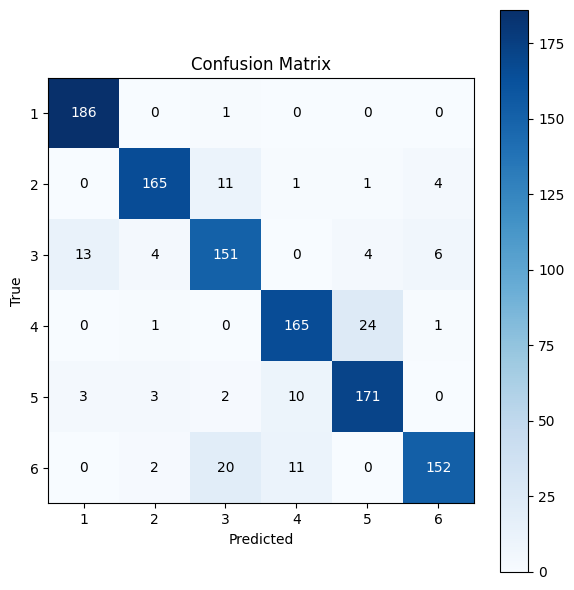


Classification Report:
               precision    recall  f1-score   support

           1      0.921     0.995     0.956       187
           2      0.943     0.907     0.924       182
           3      0.816     0.848     0.832       178
           4      0.882     0.864     0.873       191
           5      0.855     0.905     0.879       189
           6      0.933     0.822     0.874       185

    accuracy                          0.890      1112
   macro avg      0.892     0.890     0.890      1112
weighted avg      0.892     0.890     0.890      1112



In [14]:
svm_model = tune_svm(X_train=Xtr_p,y_train=ytr_ft, groups=grp_tr, param_grid={ 'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto'] }, X_test=Xte_p,
     y_test=yte_ft )



---

